# Interpretable Linear Attn Network
## AKA the super sparse (only 1 on) linear classifier

The aim of this work is to *build* a network with *attention* such that the neurons used for the final layer of classification is *interpretable*. This approach is designed to explain computer vision tasks, but can be easily extended to time series data and tabular data. The decision made is *subset linear* meaning that only a subset of concepts classes are selected for decision and the interactiion between concepts and output is linear. Note that this is different from a linear classifier in that subset linear classifiers can choose which subset of concepts to use. This selection of concepts is achieved using attention. The attention on the input has the effect of setting the weight for all other concepts to zero. 

## Contributions

1. First method to investigate subset linear classifier (makes even nonlinear relationship representable)
2. Easily spot confounding by looking at attention (no need for concept dataset to be unbiased)
3. Subset linear attention is cognitively simple to understand: use attention to focus on important concepts, and then look up their importance score through interpretable last layer

## Advantage of subset linear classifier

1. Don't have to model attention and concept correctly for not important concepts (efficiency, need experiment to back up)
2. Can account for nonlinear relationships: e.g. certain features are not reliable for one situation, while certain features are reliable for other situations (make sure the weight for a decision have the same sign, but not necessarily the same magnitude)

## Limitations

1. If spatial relation will completely reverse the linear weights, then subset linear models won't be able to capture that relationship. A future direction is to model this with a decision tree to decide mode of operation (do a soft decision tree).

## Assumptions

1. We have annotation of image segmentation (the segmentation is used to penalyze attention). 
2. The sign of the weight don't change (a concept can only be good or bad for the classification, if it is in the middle ground, ILAN will choose more robust features via attention)

## Evaluation

It's hard to evaluate the interpretability of individual neurons, but we can measure 

1. attention accuracy (as for image segmentation, say IoU)
2. classification accuracy of the concept network
3. attention switch frequency (lower switch of frequency means more robust)
4. classification accuracy of the main network

1-3 guarantees the interpretability of individual neurons, 4 guarantees the usefulness of the network.

Back to the wolf vs. snow example. If the attention is always on the snow, it means the network confuses wolf from snow.

## Extensions

1. use an uninterpretable network to learn feature mapping and the classification task; essentially use that network to guide better attention
2. add in human guidence on attention (a module that makes penalty order agnostic) for interactive learning (make it credible)
3. take state of the art segmentation method to segment data an compare the utility
4. Add self attention (global receptive field) before inputing to attention module
5. Try ACT on self attention module
6. RNN can be similarly trained but put attention on time instead
7. learn a soft decision tree module to fit different mode of weights

## Regularizations 

In this work, we present 4 different regularization terms to make a credible ILAN model.

1. $L_{data}$: classification loss (main task)
2. $L_{focus}$: link attention to concept use segmented region, set up as auxiliary task
3. $L_{\overline {focus}}$: what not to focus on, penalyze producing outside concept not in attention
4. $L_{expert}$: expert knowledge on model weight, usually penalyzed by EYE

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os, math
import matplotlib.image as mpimg
import glob, torch
import matplotlib as mpl
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from skimage import io
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler
import torch.optim as optim
import copy
from sklearn.decomposition import PCA
import seaborn as sns
import math

In [2]:
def to_var(x, *args, **kwargs):
    if type(x) is list or type(x) is tuple:
        x = [Variable(x_, *args, **kwargs) for x_ in x]
    else:
        x = Variable(x, *args, **kwargs)
    return x

## toy domain: 0-3 items on 3x3 grid 

In [3]:
class Board:
    def __init__(self, max_obj=3, w=3, h=3, repr_list=None):
        '''
        repr_list is a mapping from object number to name
        0 is always the default background
        '''
        if repr_list is not None:
            assert len(repr_list) == max_obj+1
        else:
            repr_list = [str(i) for i in range(max_obj+1)]
        self.repr_list = repr_list
            
        self.w, self.h = w, h
        self.board = np.zeros(w*h).astype(np.int)
        self.max_obj = max_obj
        self.board = self.board.reshape([w, h])

    def __repr__(self):
        res = ""
        for r in self.board:
            res += '['
            res += ", ".join(list(map(lambda x: self.repr_list[x], r)))
            res += ']\n'
        return res
    
    def to_input(self):
        return self.board.ravel()
    
def fillBoard(b): # drop in objects 1 at a time, same type only 1
    b.board = b.board.ravel()
    # either there is an item or not
    exist = []
    for i in range(1, b.max_obj+1):
        if np.random.rand() > 0.5:
            exist.append(i)
    exist = np.random.permutation(exist)
    # choose where to put those item
    where = np.random.choice(b.w*b.h, len(exist), replace=False)
    for i, p in enumerate(where):
        b.board[p] = exist[i]
    b.board = b.board.reshape([b.w, b.h])


In [4]:
w, h = 3, 3
max_obj = 3
b = Board(max_obj, w, h, ['0', 'A', 'B', 'C'])
fillBoard(b)
print(b.to_input().reshape(h, w))
print(b)

[[0 0 0]
 [0 1 0]
 [0 0 3]]
[0, 0, 0]
[0, A, 0]
[0, 0, C]



Assume the relationship is

y = sign(1A + 2B - 3C)

In other word, we don't care where A, B, C are

Further, for simplicity, we only consider 1 attention head

In [5]:
class BoardDataset(Dataset):
    
    def __init__(self, length, weight, fillBoard=fillBoard):
        '''weight is class weight: the real weight for each class'''
        self.length = length
        self.w, self.h, self.max_obj = 3, 3, 3
        self.weight = weight
        self.fillBoard = fillBoard
        
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        b = Board(self.max_obj, self.w, self.h)
        self.fillBoard(b)
        x = b.to_input()
        #y = sum([self.weight[i] for i in x])
        y = int(sum([self.weight[i] for i in x])>0)
        return x, y

In [6]:
train_portion = 0.8

board_data = BoardDataset(10000, [0, 1, 2, -3])
dataset_size = len(board_data)
splitpoint = math.floor(train_portion*dataset_size)

iter_order = np.random.permutation(dataset_size)
train_subset = iter_order[:splitpoint]
test_subset = iter_order[splitpoint:]

In [7]:
board_dataloader = DataLoader(board_data, batch_size=10, 
                              sampler=SubsetRandomSampler(train_subset),
                              num_workers=1)

x, y = next(iter(board_dataloader))
print(x)


    0     2     0     3     0     0     0     0     0
    0     0     0     0     0     0     1     0     3
    0     0     0     0     0     3     0     0     0
    0     0     1     0     0     0     0     0     0
    0     0     0     3     0     1     0     0     0
    0     0     0     1     0     0     0     0     0
    0     0     0     3     0     0     2     1     0
    0     0     0     0     0     2     0     3     0
    0     0     0     2     0     0     1     0     0
    0     0     0     0     1     0     0     0     0
[torch.LongTensor of size 10x9]



In [56]:
class SelfAttn(nn.Module):
    def __init__(self, hidden_size, num_head=1):
        super(SelfAttn, self).__init__()
        self.hidden_size = hidden_size
        self.num_head = num_head
        
        self.WQs = []
        for i in range(num_head): # multihead attention shares K and V
            self.WQs.append(nn.Linear(hidden_size, hidden_size))
        self.WK = nn.Linear(hidden_size, hidden_size)
        self.WV = nn.Linear(hidden_size, hidden_size)        
        self.sm = nn.Softmax(dim=2)
    
    def forward(self, H): # H is of size bsx9xhidden_size
        Qs = [WQ(H) for WQ in self.WQs]
        K = self.WK(H)        
        V = self.WV(H) 
        Zs = [torch.matmul(self.sm(torch.matmul(Q, K.transpose(1,2)) / np.sqrt(self.hidden_size)), V) for Q in Qs]
        return Zs

class Attn(nn.Module):
    
    def __init__(self, hidden_size, num_head=1, w=3, h=3):
        super(Attn, self).__init__()
        self.hidden_size = hidden_size
        self.num_head = num_head
        
        # summarize all spatial vectors to 1 vector
        self.Wcombine = nn.Linear(hidden_size*w*h, num_head*hidden_size)
        self.relu = nn.ReLU(inplace=True)
        self.WQ = nn.Linear(hidden_size, hidden_size)
        self.WK = nn.Linear(hidden_size, hidden_size)
        self.WV = nn.Linear(hidden_size, hidden_size)        
        self.sm = nn.Softmax(dim=2)
    
    def forward(self, H): # H is of size bsx9xhidden_size
        bs = H.shape[0]
        H_combined = self.relu(self.Wcombine(H.view(bs,-1)).view(bs, self.num_head, self.hidden_size))
        Q = self.WQ(H_combined)
        K = self.WK(H)        
        V = self.WV(H) 
        attn_weight = self.sm(torch.matmul(Q, K.transpose(1,2)) / np.sqrt(self.hidden_size))
        Z = torch.matmul(attn_weight, V)
        Zs = [Z[:,i,:] for i in range(Z.shape[1])]
        attn_weights = [attn_weight[:,i,:] for i in range(attn_weight.shape[1])]
        return Zs, attn_weights, V

class Ilan(nn.Module):

    def __init__(self, num_class=2, hidden_size=4, num_head=1, max_obj=3, w=3, h=3, mask=None):
        super(Ilan, self).__init__()
        self.max_obj = max_obj
        self.num_class = num_class
        self.hidden_size = hidden_size
        if mask is None:
            mask = to_var(torch.ones(max_obj+1))
        self.mask = mask
        
        self.embed = nn.Embedding(max_obj+1, hidden_size)
        self.attn = Attn(hidden_size, num_head, w, h)
        self.sm = nn.Softmax(dim=1)
        
        self.concept_classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, max_obj+1),            
        )
        self.classifier = nn.Linear(max_obj+1, self.num_class)
        
    def forward(self, x):
        # preprocess
        H = self.embed(x)
        # get attention: [bs x hidden_size] of length num_heads
        Zs, attn_weights, V = self.attn(H)
        # compute concept for each attention head
        concepts = [self.sm(self.concept_classifier(Z)) for Z in Zs]
        # compute final linear decision
        o = self.classifier(sum(concepts) * self.mask)
        return concepts, attn_weights, o, V

In [9]:
trainloader = DataLoader(board_data, batch_size=32, 
                         sampler=SubsetRandomSampler(train_subset),
                         num_workers=1)
testloader = DataLoader(board_data, batch_size=32, 
                        sampler=SubsetRandomSampler(test_subset),
                        num_workers=1)


In [10]:
def criterion_crossentropy(outputs, y):
    concepts, attentions, outputs, V = outputs
    loss = nn.CrossEntropyLoss()(outputs, y) 
    return loss

def train(net, trainloader, criterion, optimizer, print_every=10, epochs=2):

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(to_var(inputs))
            loss = criterion(outputs, to_var(labels))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data[0]
            if i % print_every == (print_every-1): 
                print('[%d, %5d] loss: %.10f' %
                      (epoch + 1, i + 1, running_loss / print_every))
                running_loss = 0.0

    print('Finished Training')

def formatFloatList(l, decimal=5):
    fstring = "%%.%df" % decimal
    res = ", ".join([fstring % i for i in l])
    return '[' + res + ']'

def plotAttn(a_s, x, c):
    for k, a in enumerate(a_s):
        plt.figure(figsize=(10,10))
        #plt.figure()
        ax2=plt.subplot(1,2,2, aspect='equal', adjustable='box-forced')
        sns.heatmap(c[k].data.numpy(), annot=True, fmt=".1f", vmin=0, vmax=1, cbar=False)
        plt.title('concepts softmax')
        
        ax1 = plt.subplot(1,2,1, aspect='equal', adjustable='box-forced', sharex=ax2)#, sharey=ax2)
        ax1.get_xaxis().set_visible(False)
        plt.imshow(a.data.numpy(), vmin=0, vmax=1)
        for (i, j), z in np.ndenumerate(x):
            plt.gca().text(j, i, '{:d}'.format(z), ha='center', va='center', color='r')
        plt.title('attention map %d' % k)
        
        #print("concepts:", torch.max(c[k], 1)[1].data.numpy())
        plt.show()
    
def show_acc(net, loader, name=""):
    correct = 0
    total = 0

    for data in loader:
        x, y = data
        x, y = to_var(x), to_var(y)
        _, _, outputs, _ = net(x)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y.data).sum()

    print('Accuracy of the network on %d %s images: %d %%' % (len(loader.sampler), name, 100 * correct / total))

In [11]:
net = Ilan(num_class=2, max_obj=max_obj, w=w, h=h)
concepts, attn_weights, o, V = net(to_var(x))    

In [12]:
criterion = criterion_crossentropy
optimizer = optim.Adam(net.parameters())
train(net, trainloader, criterion, optimizer, print_every=100, epochs=10)

[1,   100] loss: 0.6617482626
[1,   200] loss: 0.6541054952
[2,   100] loss: 0.6598008686
[2,   200] loss: 0.6118395269
[3,   100] loss: 0.3224825186
[3,   200] loss: 0.2387669373
[4,   100] loss: 0.1732127050
[4,   200] loss: 0.1434235325
[5,   100] loss: 0.1145677684
[5,   200] loss: 0.0992423980
[6,   100] loss: 0.0830195984
[6,   200] loss: 0.0735899336
[7,   100] loss: 0.0632235835
[7,   200] loss: 0.0568603456
[8,   100] loss: 0.0497297312
[8,   200] loss: 0.0451798171
[9,   100] loss: 0.0400266906
[9,   200] loss: 0.0366387491
[10,   100] loss: 0.0327784381
[10,   200] loss: 0.0301781943
Finished Training


In [13]:
show_acc(net, testloader, 'test')
show_acc(net, trainloader, 'train')

Accuracy of the network on 2000 test images: 100 %
Accuracy of the network on 8000 train images: 100 %


weight: [-0.54, -3.46, 1.23, 3.58]


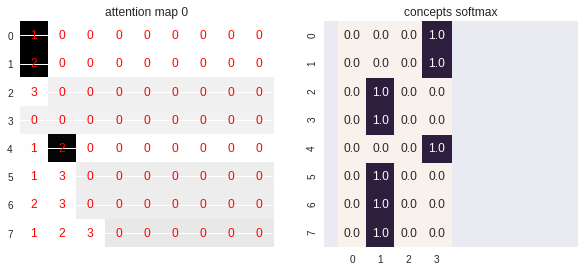

output 0: [0.04, 0.96]
output 1: [0.04, 0.96]
output 2: [0.98, 0.02]
output 3: [0.98, 0.02]
output 4: [0.04, 0.96]
output 5: [0.98, 0.02]
output 6: [0.98, 0.02]
output 7: [0.98, 0.02]


In [14]:
x1 = torch.LongTensor([[1,0,0,0,0,0,0,0,0],
                       [2,0,0,0,0,0,0,0,0],
                       [3,0,0,0,0,0,0,0,0],
                       [0,0,0,0,0,0,0,0,0],
                       [1,2,0,0,0,0,0,0,0],
                       [1,3,0,0,0,0,0,0,0],
                       [2,3,0,0,0,0,0,0,0],
                       [1,2,3,0,0,0,0,0,0]])

c, a, o, v = net(to_var(x1))
W = net.classifier.weight

weight = (W[1] - W[0]).data.numpy()
print('weight:', formatFloatList(weight,2))
plotAttn(a, x1, c)
for i, r in enumerate(net.sm(o).data.numpy()):
    print('output %d:' % i, formatFloatList(r, 2))


# 2 attention heads

In [15]:
net2 = Ilan(num_class=2, max_obj=max_obj, w=w, h=h, num_head=2)
concepts, attn_weights, o, v = net2(to_var(x))

In [16]:
criterion = criterion_crossentropy
optimizer2 = optim.Adam(net2.parameters())

train(net2, trainloader, criterion, optimizer2, print_every=100, epochs=10)

[1,   100] loss: 0.6597346115
[1,   200] loss: 0.6511538202
[2,   100] loss: 0.5772115025
[2,   200] loss: 0.3543908650
[3,   100] loss: 0.1864445844
[3,   200] loss: 0.1113435654
[4,   100] loss: 0.0693779121
[4,   200] loss: 0.0534447733
[5,   100] loss: 0.0398151488
[5,   200] loss: 0.0328099043
[6,   100] loss: 0.0261729760
[6,   200] loss: 0.0223528090
[7,   100] loss: 0.0185654478
[7,   200] loss: 0.0162158166
[8,   100] loss: 0.0138322105
[8,   200] loss: 0.0122688248
[9,   100] loss: 0.0106650217
[9,   200] loss: 0.0095656072
[10,   100] loss: 0.0084324544
[10,   200] loss: 0.0076270148
Finished Training


In [17]:
show_acc(net2, testloader, 'test')
show_acc(net2, trainloader, 'train')

Accuracy of the network on 2000 test images: 100 %
Accuracy of the network on 8000 train images: 100 %


weight: [2.26, 1.94, -3.12, 0.31]


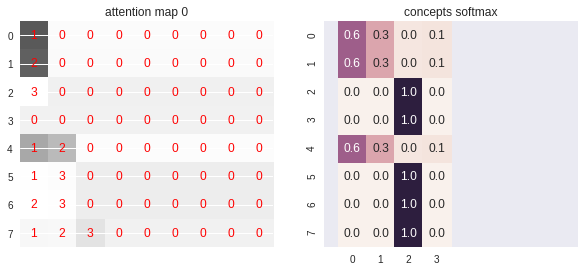

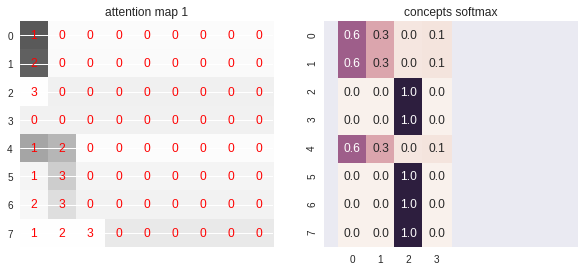

output 0: [0.01, 0.99]
output 1: [0.01, 0.99]
output 2: [1.00, 0.00]
output 3: [1.00, 0.00]
output 4: [0.01, 0.99]
output 5: [1.00, 0.00]
output 6: [1.00, 0.00]
output 7: [1.00, 0.00]


In [18]:
x1 = torch.LongTensor([[1,0,0,0,0,0,0,0,0],
                       [2,0,0,0,0,0,0,0,0],
                       [3,0,0,0,0,0,0,0,0],
                       [0,0,0,0,0,0,0,0,0],
                       [1,2,0,0,0,0,0,0,0],
                       [1,3,0,0,0,0,0,0,0],
                       [2,3,0,0,0,0,0,0,0],
                       [1,2,3,0,0,0,0,0,0]])

c, a, o, v = net2(to_var(x1))
W = net2.classifier.weight

weight = (W[1] - W[0]).data.numpy()
print('weight:', formatFloatList(weight,2))
plotAttn(a, x1, c)
for i, r in enumerate(net.sm(o).data.numpy()):
    print('output %d:' % i, formatFloatList(r, 2))


# train with multiple objective: fix attention to concept association

## A documentation of the concept loss below

0. data_loss
1. concept_classification_loss
2. weight_decay

1.1 max_attn_concept

Force the detected concept towards the maximum attention concept in image annotation.
- Attention could be too large that the maximum attn concept is not the true target

1.2 max_attn_concept_pixel

Similar to 1.1, but opens a new channel and penalyze the concept detected only using the maximum detection concept bounding box, thus avoiding problem in 1.1

1.3 not_in_attention

prevent the network from reporting concepts not in attention by finding objects in region with attention >= median sample attention and penalyze concept activation for those not in the set of objects

2.1 weighted_l2_decay

penalyze last layer weight with weighted l2

2.2 weighted_concept_decay

penalyze last layer input to not activate for certain concepts
- in conflict with objective 1.3

criteria_name | data_loss (0) | max_attn_concept (1.1) | max_attn_concept_pixel (1.2) | not_in_attention (1.3) | weighted_l2_decay (2.1) | weighted_concept_decay (2.2)
---|---|---|---|---
criterion_cross_entropy|1|0|0|0|0|0
mode0|1|1|0|0|0|0
mode1|1|0|1|0|1|0
mode2|1|0|1|0|0|1
mode3|1|0|1|1|0|1
mode4|1|0|1|1|1|0

My recommendation is to use mode 4



In [50]:
def ConceptLoss(weight=1, mode=4, risk_factor=None):
    '''weight: weight to differnt losses, if 1 means all equal'''
    
    def criterion_concept0(net, x, outputs, y): # doesn't make concept detector work with overall goal
        concepts, attentions, outputs, v = outputs
        losses = []
        losses.append(nn.CrossEntropyLoss()(outputs, y))  # dataloss
        # use attention to determine concepts
        for c, a in zip(concepts, attentions):
            # take the max of attention and see what's there
            _, m = torch.max(a, dim=1)
            real_c = x[torch.arange(len(m)).long(), m.data]
            losses.append(nn.CrossEntropyLoss()(c, real_c))
        if weight == 1:
            return losses
        else:
            assert len(weight) == len(losses)
            return [w * l for w, l in zip(weight, losses)]

    def criterion_concept1(net, x, outputs, y): # add in attention to concept loss
        concepts, attentions, outputs, v = outputs
        losses = []
        losses.append(nn.CrossEntropyLoss()(outputs, y))  # dataloss
        # use attention to determine concepts
        for c, a in zip(concepts, attentions):
            # take the max of attention and see what's there
            _, m = torch.max(a, dim=1)
            real_c = x[torch.arange(len(m)).long(), m.data]
            # penalyze the real bounding box bounded concept: v: bs x 9 x hidden_size
            #                                                 a: bs x 1 x 9
            bs, ndigits = a.shape
            newa = torch.zeros(bs, ndigits)
            newa[torch.arange(len(m)).long(), m.data] = 1
            newa = to_var(newa.unsqueeze(1))
            
            value = torch.matmul(newa, v).squeeze(1)
            c = net.concept_classifier(value)

            losses.append(nn.CrossEntropyLoss()(c, real_c))
            
        if risk_factor is not None:
            W = net.classifier.weight
            losses.append(sum((W[1] - W[0])**2 * risk_factor))
            
        if weight == 1:
            return losses
        else:
            assert len(weight) == len(losses)
            return [w * l for w, l in zip(weight, losses)]
        
    def criterion_concept2(net, x, outputs, y): # constrain risk factor with less attention
        concepts, attentions, outputs, v = outputs
        losses = []
        losses.append(nn.CrossEntropyLoss()(outputs, y))  # dataloss
        # use attention to determine concepts
        for c, a in zip(concepts, attentions):
            # take the max of attention and see what's there
            _, m = torch.max(a, dim=1)
            real_c = x[torch.arange(len(m)).long(), m.data]
            # penalyze the real bounding box bounded concept: v: bs x 9 x hidden_size
            #                                                 a: bs x 1 x 9
            bs, ndigits = a.shape
            newa = torch.zeros(bs, ndigits)
            newa[torch.arange(len(m)).long(), m.data] = 1
            newa = to_var(newa.unsqueeze(1))
            
            value = torch.matmul(newa, v).squeeze(1)
            c_ = net.concept_classifier(value)

            losses.append(nn.CrossEntropyLoss()(c_, real_c))
            
        if risk_factor is not None:
            losses.append(torch.sum(sum(concepts) * risk_factor))
            
        if weight == 1:
            return losses
        else:
            assert len(weight) == len(losses)
            return [w * l for w, l in zip(weight, losses)]


    def criterion_concept3(net, x, outputs, y): # constrain attention leads to concept not in attention
        concepts, attentions, outputs, v = outputs
        losses = []
        losses.append(nn.CrossEntropyLoss()(outputs, y))  # dataloss
        # use attention to determine concepts
        for c, a in zip(concepts, attentions):
            # todo: form a mask m on c based on attention over median in each example
            mask_a = a.ge(torch.median(a, dim=1)[0].unsqueeze(1))
            # find out what's not there
            mask_c = torch.ones_like(c)
            maska_selected = (x+1) * mask_a.long() - 1

            for i, r in enumerate(maska_selected.data):
                for j in set(r):
                    if j != -1:
                        mask_c[i, j] = 0
            losses.append(torch.sum(mask_c * c))
            
            # take the max of attention and see what's there
            _, m = torch.max(a, dim=1)
            real_c = x[torch.arange(len(m)).long(), m.data]
            # penalyze the real bounding box bounded concept: v: bs x 9 x hidden_size
            #                                                 a: bs x 1 x 9
            bs, ndigits = a.shape
            newa = torch.zeros(bs, ndigits)
            newa[torch.arange(len(m)).long(), m.data] = 1
            newa = to_var(newa.unsqueeze(1))
            
            value = torch.matmul(newa, v).squeeze(1)
            c_ = net.concept_classifier(value)

            losses.append(nn.CrossEntropyLoss()(c_, real_c))
            
        if risk_factor is not None:
            losses.append(torch.sum(sum(concepts) * risk_factor))
            
        if weight == 1:
            return losses
        else:
            assert len(weight) == len(losses)
            return [w * l for w, l in zip(weight, losses)]

    def criterion_concept4(net, x, outputs, y): # concept3 with penalyze W instead of activation of concept
        concepts, attentions, outputs, v = outputs
        losses = []
        losses.append(nn.CrossEntropyLoss()(outputs, y))  # dataloss
        # use attention to determine concepts
        for c, a in zip(concepts, attentions):
            # todo: form a mask m on c based on attention over median in each example
            mask_a = a.ge(torch.median(a, dim=1)[0].unsqueeze(1))
            # find out what's not there
            mask_c = torch.ones_like(c)
            maska_selected = (x+1) * mask_a.long() - 1

            for i, r in enumerate(maska_selected.data):
                for j in set(r):
                    if j != -1:
                        mask_c[i, j] = 0
            losses.append(torch.sum(mask_c * c))
            
            # take the max of attention and see what's there
            _, m = torch.max(a, dim=1)
            real_c = x[torch.arange(len(m)).long(), m.data]
            # penalyze the real bounding box bounded concept: v: bs x 9 x hidden_size
            #                                                 a: bs x 1 x 9
            bs, ndigits = a.shape
            newa = torch.zeros(bs, ndigits)
            newa[torch.arange(len(m)).long(), m.data] = 1
            newa = to_var(newa.unsqueeze(1))
            
            value = torch.matmul(newa, v).squeeze(1)
            c_ = net.concept_classifier(value)

            losses.append(nn.CrossEntropyLoss()(c_, real_c))
            
        if risk_factor is not None:
            W = net.classifier.weight
            losses.append(sum((W[1] - W[0])**2 * risk_factor))
            
        if weight == 1:
            return losses
        else:
            assert len(weight) == len(losses)
            return [w * l for w, l in zip(weight, losses)]

    mode_changer = [criterion_concept0, criterion_concept1, criterion_concept2, 
                    criterion_concept3, criterion_concept4]
    return mode_changer[mode]

def train3(net, trainloader, criterion, optimizer, print_every=10, epochs=2):

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = []
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = to_var(inputs), to_var(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            losses = criterion(net, inputs, outputs, labels)
            sum(losses).backward()
            optimizer.step()

            # print statistics
            if len(running_loss) != len(losses):
                running_loss = np.zeros(len(losses))
            running_loss += np.array(list(map(lambda loss: loss.data[0], losses)))
            if i % print_every == (print_every-1): 
                print('[%d, %5d] losses: %s' %
                      (epoch + 1, i + 1, formatFloatList(running_loss / print_every)))
                running_loss = []

    print('Finished Training')


In [21]:
net3 = Ilan(num_class=2, max_obj=max_obj, w=w, h=h, num_head=1)

In [22]:
criterion3 = ConceptLoss(weight=[1, 0.1], mode=1)
optimizer3 = optim.Adam(net3.parameters())

train3(net3, trainloader, criterion3, optimizer3, print_every=100, epochs=10)

[1,   100] losses: [0.68172, 0.12945]
[1,   200] losses: [0.66007, 0.09755]
[2,   100] losses: [0.66002, 0.10176]
[2,   200] losses: [0.65386, 0.05782]
[3,   100] losses: [0.64376, 0.02671]
[3,   200] losses: [0.63055, 0.02400]
[4,   100] losses: [0.62034, 0.02082]
[4,   200] losses: [0.56327, 0.02292]
[5,   100] losses: [0.45230, 0.01051]
[5,   200] losses: [0.36852, 0.00997]
[6,   100] losses: [0.25294, 0.01385]
[6,   200] losses: [0.20101, 0.01218]
[7,   100] losses: [0.15199, 0.00993]
[7,   200] losses: [0.12743, 0.00897]
[8,   100] losses: [0.10264, 0.00742]
[8,   200] losses: [0.08896, 0.00662]
[9,   100] losses: [0.07457, 0.00569]
[9,   200] losses: [0.06603, 0.00527]
[10,   100] losses: [0.05680, 0.00459]
[10,   200] losses: [0.05103, 0.00426]
Finished Training


In [23]:
show_acc(net3, testloader, 'test')
show_acc(net3, trainloader, 'train')

Accuracy of the network on 2000 test images: 100 %
Accuracy of the network on 8000 train images: 100 %


weight: [-4.06, -1.81, 2.54, 1.99]


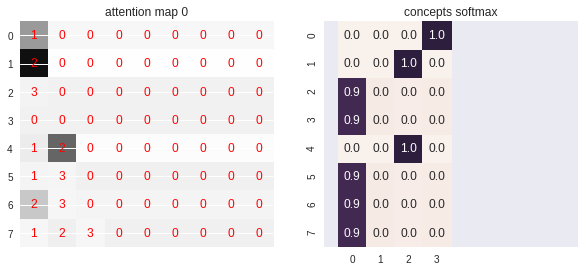

output 0: [0.09, 0.91]
output 1: [0.06, 0.94]
output 2: [0.97, 0.03]
output 3: [0.97, 0.03]
output 4: [0.06, 0.94]
output 5: [0.97, 0.03]
output 6: [0.97, 0.03]
output 7: [0.97, 0.03]


In [24]:
x1 = torch.LongTensor([[1,0,0,0,0,0,0,0,0],
                       [2,0,0,0,0,0,0,0,0],
                       [3,0,0,0,0,0,0,0,0],
                       [0,0,0,0,0,0,0,0,0],
                       [1,2,0,0,0,0,0,0,0],
                       [1,3,0,0,0,0,0,0,0],
                       [2,3,0,0,0,0,0,0,0],
                       [1,2,3,0,0,0,0,0,0]])

c, a, o, v = net3(to_var(x1))
W = net3.classifier.weight

weight = (W[1] - W[0]).data.numpy()
print('weight:', formatFloatList(weight,2))
plotAttn(a, x1, c)
for i, r in enumerate(net.sm(o).data.numpy()):
    print('output %d:' % i, formatFloatList(r, 2))


weight: [-4.06, -1.81, 2.54, 1.99]


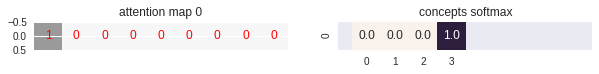

output 0: [0.09, 0.91]
weight: [-4.06, -1.81, 2.54, 1.99]


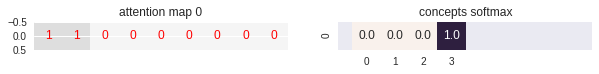

output 0: [0.10, 0.90]
weight: [-4.06, -1.81, 2.54, 1.99]


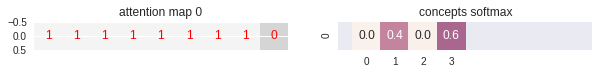

output 0: [0.35, 0.65]


In [25]:
x1 = torch.LongTensor([1,0,0,0,0,0,0,0,0])
x1 = x1.unsqueeze(0)
c, a, o, v = net3(to_var(x1))

weight = (W[1] - W[0]).data.numpy()
print('weight:', formatFloatList(weight,2))
plotAttn(a, x1, c)
for i, r in enumerate(net.sm(o).data.numpy()):
    print('output %d:' % i, formatFloatList(r, 2))

############################################
x1 = torch.LongTensor([1,1,0,0,0,0,0,0,0])
x1 = x1.unsqueeze(0)
c, a, o, v = net3(to_var(x1))

weight = (W[1] - W[0]).data.numpy()
print('weight:', formatFloatList(weight,2))
plotAttn(a, x1, c)
for i, r in enumerate(net.sm(o).data.numpy()):
    print('output %d:' % i, formatFloatList(r, 2))
    
############################################
x1 = torch.LongTensor([1,1,1,1,1,1,1,1,0])
x1 = x1.unsqueeze(0)
c, a, o, v = net3(to_var(x1))

weight = (W[1] - W[0]).data.numpy()
print('weight:', formatFloatList(weight,2))
plotAttn(a, x1, c)
for i, r in enumerate(net.sm(o).data.numpy()):
    print('output %d:' % i, formatFloatList(r, 2))

The above example shows that ILAN's attention is really hard to predict. But it is still ok, I mean it's a perfectly fine interpretation. It just means the network thinks the example is negative because it sees 0 and 0 is in general negative.

# fix wrong attention

In [63]:
net4 = Ilan(num_class=2, max_obj=max_obj, w=w, h=h, num_head=1, mask=to_var(torch.FloatTensor([0,1,1,1])))

In [64]:
# data_loss, not focus loss, focus loss, risk_factor_loss
#criterion4 = ConceptLoss(weight=[1, 0.01, 0.1, 0.01], mode=3, risk_factor=to_var(torch.FloatTensor([1,0,0,0])))
criterion4 = ConceptLoss(weight=[1, 0.01, 0.1, 0.00], mode=3, risk_factor=to_var(torch.FloatTensor([1,0,0,0])))
optimizer4 = optim.Adam(net4.parameters())

train3(net4, trainloader, criterion4, optimizer4, print_every=100, epochs=10)

[1,   100] losses: [0.66797, 0.14405, 0.10415, 0.00000]
[1,   200] losses: [0.59750, 0.07888, 0.05341, 0.00000]
[2,   100] losses: [0.52597, 0.01471, 0.00491, 0.00000]
[2,   200] losses: [0.48901, 0.00442, 0.00144, 0.00000]
[3,   100] losses: [0.46403, 0.00165, 0.00053, 0.00000]
[3,   200] losses: [0.43522, 0.00099, 0.00032, 0.00000]
[4,   100] losses: [0.42058, 0.00058, 0.00019, 0.00000]
[4,   200] losses: [0.39689, 0.00042, 0.00014, 0.00000]
[5,   100] losses: [0.38927, 0.00029, 0.00009, 0.00000]
[5,   200] losses: [0.36897, 0.00022, 0.00007, 0.00000]
[6,   100] losses: [0.36639, 0.00017, 0.00006, 0.00000]
[6,   200] losses: [0.34836, 0.00014, 0.00004, 0.00000]
[7,   100] losses: [0.34946, 0.00011, 0.00004, 0.00000]
[7,   200] losses: [0.33296, 0.00009, 0.00003, 0.00000]
[8,   100] losses: [0.33680, 0.00008, 0.00002, 0.00000]
[8,   200] losses: [0.32134, 0.00006, 0.00002, 0.00000]
[9,   100] losses: [0.32721, 0.00005, 0.00002, 0.00000]
[9,   200] losses: [0.31246, 0.00005, 0.00002, 0

In [61]:
show_acc(net4, testloader, 'test')
show_acc(net4, trainloader, 'train')

Accuracy of the network on 2000 test images: 62 %
Accuracy of the network on 8000 train images: 63 %


weight: [0.69, -0.81, -0.22, -1.04]


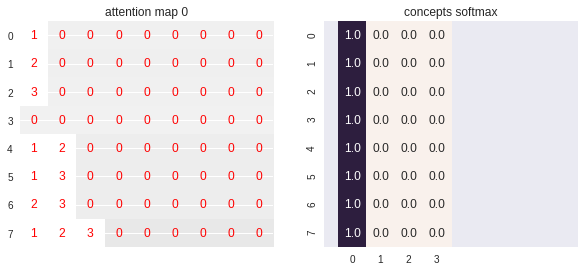

output 0: [0.64, 0.36]
output 1: [0.64, 0.36]
output 2: [0.64, 0.36]
output 3: [0.64, 0.36]
output 4: [0.64, 0.36]
output 5: [0.64, 0.36]
output 6: [0.64, 0.36]
output 7: [0.64, 0.36]


In [62]:
x1 = torch.LongTensor([[1,0,0,0,0,0,0,0,0],
                       [2,0,0,0,0,0,0,0,0],
                       [3,0,0,0,0,0,0,0,0],
                       [0,0,0,0,0,0,0,0,0],
                       [1,2,0,0,0,0,0,0,0],
                       [1,3,0,0,0,0,0,0,0],
                       [2,3,0,0,0,0,0,0,0],
                       [1,2,3,0,0,0,0,0,0]])

c, a, o, v = net4(to_var(x1))
W = net4.classifier.weight

weight = (W[1] - W[0]).data.numpy()
print('weight:', formatFloatList(weight,2))
plotAttn(a, x1, c)
for i, r in enumerate(net.sm(o).data.numpy()):
    print('output %d:' % i, formatFloatList(r, 2))


summary:

Good regularization saves the day. In this case, we have data loss, attention to concept link loss (make sure concept matches attention), and attention risk factor loss (penalyze background noise attention).

Although this is a very small toy set (in fact, since our attention ignores spatial order, there are only 8 cases to consider), I think the result is encouraging.

# Recreate the wolf (2) v.s. snow (1) v.s. dog (3) with background (0) problem

The basic setup is wolf (2) has background with snow (1) and noise (0), dog (3) only have regular background (0), the classification task is to find if there is a wolf:

y = 0 x background + 0 x snow + 1 x wolf + 0 x dog

In [30]:
def fillWolfBoard(b):
    '''
    constraints:
    1. only have 1 wolf or 1 dog, not both
    2. whenever there is a wolf, there is 20% - 80% snow
    '''
    b.board = b.board.ravel()
    exist = []
    # decide is wolf or dog
    if np.random.random() > 0.5:
        exist.append(2) # wolf
        left = b.w * b.h - 1
        n_snows = np.random.choice(range(math.ceil(left * 0.2), math.floor(left * 0.8)))
        exist.extend([1] * n_snows)
    else:
        exist.append(3) # dog
        
    exist.extend([0] * (b.w*b.h-len(exist)))
    exist = np.random.permutation(exist)
    b.board = np.array(exist)
        
    b.board = b.board.reshape(b.w, b.h)     

In [31]:
w, h = 3, 3
max_obj = 3
b = Board(max_obj, w, h, ['0', 'S', 'W', 'D'])
fillWolfBoard(b)
#print(b.to_input().reshape(h, w))
print(b)

[0, 0, 0]
[0, 0, 0]
[0, D, 0]



In [32]:
wolf_data = BoardDataset(10000, weight=[0, 0, 1, 0], fillBoard=fillWolfBoard)
wolf_dataloader = DataLoader(wolf_data, batch_size=10, 
                              sampler=SubsetRandomSampler(train_subset),
                              num_workers=1)

x, y = next(iter(wolf_dataloader))

In [33]:
trainloader_wolf = DataLoader(wolf_data, batch_size=32, 
                         sampler=SubsetRandomSampler(train_subset),
                         num_workers=1)
testloader_wolf = DataLoader(wolf_data, batch_size=32, 
                        sampler=SubsetRandomSampler(test_subset),
                        num_workers=1)


In [34]:
net_wolf = Ilan(num_class=2, max_obj=max_obj, w=w, h=h, num_head=1)

In [35]:
# data_loss, not link loss, link loss, risk_factor_loss
criterion_wolf = ConceptLoss(weight=[1, 0.01, 0.1, 0.01], mode=4, 
                             risk_factor=to_var(torch.FloatTensor([1,1,0,0])))
optimizer_wolf = optim.Adam(net_wolf.parameters())

train3(net_wolf, trainloader_wolf, criterion_wolf, optimizer_wolf, print_every=100, epochs=10)

[1,   100] losses: [0.69145, 0.11193, 0.05693, 0.00216]
[1,   200] losses: [0.69308, 0.02117, 0.00756, 0.00169]
[2,   100] losses: [0.69317, 0.00132, 0.00046, 0.00110]
[2,   200] losses: [0.69328, 0.00052, 0.00018, 0.00085]
[3,   100] losses: [0.69327, 0.00021, 0.00007, 0.00080]
[3,   200] losses: [0.69328, 0.00014, 0.00005, 0.00070]
[4,   100] losses: [0.69327, 0.00008, 0.00003, 0.00071]
[4,   200] losses: [0.69328, 0.00006, 0.00002, 0.00063]
[5,   100] losses: [0.69327, 0.00004, 0.00002, 0.00064]
[5,   200] losses: [0.69328, 0.00004, 0.00001, 0.00057]
[6,   100] losses: [0.69327, 0.00003, 0.00001, 0.00058]
[6,   200] losses: [0.69328, 0.00002, 0.00001, 0.00051]
[7,   100] losses: [0.69327, 0.00002, 0.00001, 0.00052]
[7,   200] losses: [0.69327, 0.00002, 0.00001, 0.00046]
[8,   100] losses: [0.69327, 0.00001, 0.00000, 0.00047]
[8,   200] losses: [0.69327, 0.00001, 0.00000, 0.00041]
[9,   100] losses: [0.69326, 0.00001, 0.00000, 0.00043]
[9,   200] losses: [0.69327, 0.00001, 0.00000, 0

In [36]:
show_acc(net_wolf, testloader_wolf, 'test')
show_acc(net_wolf, trainloader_wolf, 'train')

Accuracy of the network on 2000 test images: 49 %
Accuracy of the network on 8000 train images: 49 %


weight: [-0.18, 0.00, 0.06, -0.39]


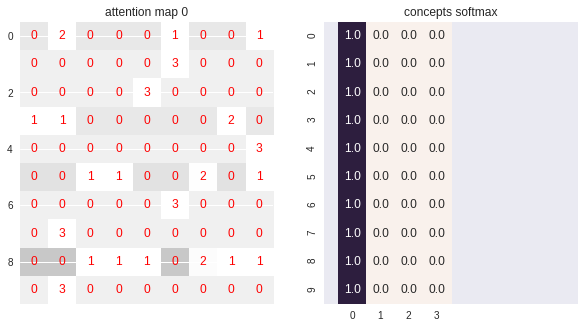

In [37]:
x1 = x
c, a, o, v = net_wolf(to_var(x1))
W = net_wolf.classifier.weight

weight = (W[1] - W[0]).data.numpy()
print('weight:', formatFloatList(weight,2))
plotAttn(a, x1, c)

Lesson learned:

1. once in local optima, it's hard to fix
2. penalyzing concept activation is in conflict with penalyzing not seen concept in attention, so penalyze final layer weight instead

# An example learned confounder

In [38]:
net_wolf2 = Ilan(num_class=2, max_obj=max_obj, w=w, h=h, num_head=1)

In [39]:
# data_loss, not link loss, link loss, risk_factor_loss
criterion_wolf2 = ConceptLoss(weight=[1, 0.01, 0.1, 1e-3], mode=4, 
                              risk_factor=to_var(torch.FloatTensor([0,0,0,0])))
optimizer_wolf2 = optim.Adam(net_wolf2.parameters())

train3(net_wolf2, trainloader_wolf, criterion_wolf2, optimizer_wolf2, print_every=100, epochs=10)

[1,   100] losses: [0.69361, 0.18411, 0.15148, 0.00000]
[1,   200] losses: [0.69371, 0.16882, 0.11278, 0.00000]
[2,   100] losses: [0.69439, 0.01469, 0.00540, 0.00000]
[2,   200] losses: [0.69328, 0.00303, 0.00107, 0.00000]
[3,   100] losses: [0.69327, 0.00104, 0.00036, 0.00000]
[3,   200] losses: [0.69327, 0.00065, 0.00023, 0.00000]
[4,   100] losses: [0.69325, 0.00038, 0.00013, 0.00000]
[4,   200] losses: [0.69327, 0.00028, 0.00010, 0.00000]
[5,   100] losses: [0.69325, 0.00020, 0.00007, 0.00000]
[5,   200] losses: [0.69327, 0.00016, 0.00005, 0.00000]
[6,   100] losses: [0.69325, 0.00012, 0.00004, 0.00000]
[6,   200] losses: [0.69327, 0.00010, 0.00003, 0.00000]
[7,   100] losses: [0.69325, 0.00008, 0.00003, 0.00000]
[7,   200] losses: [0.69327, 0.00007, 0.00002, 0.00000]
[8,   100] losses: [0.69325, 0.00005, 0.00002, 0.00000]
[8,   200] losses: [0.69327, 0.00005, 0.00002, 0.00000]
[9,   100] losses: [0.69325, 0.00004, 0.00001, 0.00000]
[9,   200] losses: [0.69327, 0.00004, 0.00001, 0

In [40]:
show_acc(net_wolf2, testloader_wolf, 'test')
show_acc(net_wolf2, trainloader_wolf, 'train')

Accuracy of the network on 2000 test images: 49 %
Accuracy of the network on 8000 train images: 49 %


weight: [0.10, -0.21, -0.04, -0.05]


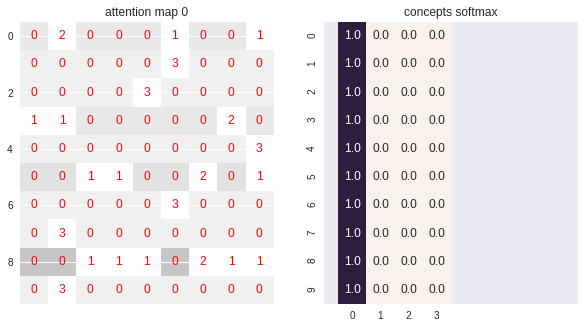

output 0: [0.50, 0.50]
output 1: [0.50, 0.50]
output 2: [0.50, 0.50]
output 3: [0.50, 0.50]
output 4: [0.50, 0.50]
output 5: [0.50, 0.50]
output 6: [0.50, 0.50]
output 7: [0.50, 0.50]
output 8: [0.50, 0.50]
output 9: [0.50, 0.50]


In [41]:
x1 = x
c, a, o, v = net_wolf2(to_var(x1))
W = net_wolf2.classifier.weight

weight = (W[1] - W[0]).data.numpy()
print('weight:', formatFloatList(weight,2))
plotAttn(a, x1, c)
for i, r in enumerate(net.sm(o).data.numpy()):
    print('output %d:' % i, formatFloatList(r, 2))


weight: [0.10, -0.21, -0.04, -0.05]


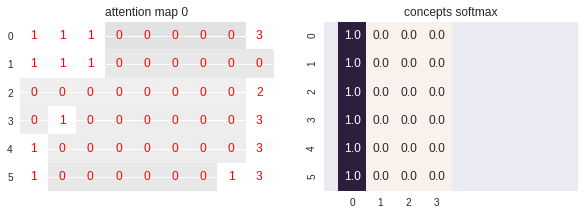

output 0: [0.50, 0.50]
output 1: [0.50, 0.50]
output 2: [0.50, 0.50]
output 3: [0.50, 0.50]
output 4: [0.50, 0.50]
output 5: [0.50, 0.50]


In [42]:
x1 = torch.LongTensor([[1,1,1,0,0,0,0,0,3],
                       [1,1,1,0,0,0,0,0,0],                       
                       [0,0,0,0,0,0,0,0,2],
                       [0,1,0,0,0,0,0,0,3],                       
                       [1,0,0,0,0,0,0,0,3],                            
                       [1,0,0,0,0,0,0,1,3],                                                   
                      ])

c, a, o, v = net_wolf2(to_var(x1))
W = net_wolf2.classifier.weight

weight = (W[1] - W[0]).data.numpy()
print('weight:', formatFloatList(weight,2))
plotAttn(a, x1, c)
for i, r in enumerate(net.sm(o).data.numpy()):
    print('output %d:' % i, formatFloatList(r, 2))


# Remaining issues and next steps

1. add more classes, more noise
2. can we do per case penalty? yes we should be able to do: do this by really setting unwanted concept 
3. add in spatial information in attention
4. try on image dataset (CIFAR10 or any pixel level annotation dataset)

## an important question: How to fix interpretation error once the model is learned?

So with ILAN we easily spot confounding, but can we fix confounding? Without retraining from scratch?

I hypothesis we can by adding a backdoor path (uninterpretable neuron network) that are initially constrained to not to be used, but after we identify a problem in the interpretable network, we can use the uninterpretable network to absorb to huge loss in trying to remedy for interpretable one.

**This requires the network to predict the amount of benefit to be unlocked and allocate this weight to let the network go backward and refine its decision!**